In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py as h5py
from keras.applications import inception_v3 as i3
from keras.applications import vgg19
from keras import optimizers
from keras.models import Model
from keras.layers import Dropout, Flatten, Dense
from keras.preprocessing.image import img_to_array, array_to_img, ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from extras import *

In [4]:
df = pd.read_pickle('labeled_data.pkl')

In [5]:
width = 224
height = 224
model = vgg19.VGG19(weights='imagenet', include_top=False, input_shape=(width, height, 3))

80142336/80134624 [==============================] - 49s    


In [6]:
for layer in model.layers[:5]:
    layer.trainable = False

x = model.output
x = Flatten()(x)
x = Dense(1024, activation="relu", name="dense_custom0")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu", name="dense_custom1")(x)
predictions = Dense(2, activation="softmax", name="predictions")(x)

model_final = Model(inputs = model.input, outputs = predictions)
model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])
# model_final.compile(loss = "sparse_categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])


In [5]:
# # add_normalized_column(df, 299, 299, 'original', 'inception_v3_input')
# add_normalized_column(df, width, height, 'original', 'vgg19_input')

In [13]:
#input_column = 'inception_v3_input'
# input_column = 'vgg19_input'
input_column = 'original'
output_column = 'mariona_y'
xs = np.array([ resize_image(img, width, height) for img in df[df[output_column].notnull()][input_column].as_matrix() ])
xs = np.array([ e for e in xs])
ys = df[df[output_column].notnull()][output_column].as_matrix()
# One Hot Encoding ys
ohe_idxs = ys.astype(int)
ys = np.zeros( (len(ys), 2) )
ys[np.arange(ohe_idxs.shape[0]), ohe_idxs] = 1.0

n_samples = len(xs)
indexes = np.random.choice(n_samples, n_samples/10)
train_xs  = np.delete(xs, indexes, axis=0)
train_ys  = np.delete(ys, indexes, axis=0)
test_xs = xs[indexes]
test_ys = ys[indexes]
n_training_samples = len(train_xs)
n_validation_samples = len(test_xs)

In [14]:
def data_generator(samples, labels, batch_size):
    while True:
        indexes = np.random.randint(len(samples), size=batch_size)
        yield samples[indexes], labels[indexes]

In [15]:
datagen = ImageDataGenerator(   
    horizontal_flip = True,
    zoom_range = 0.2,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
)

datagen.fit(xs)

In [16]:
checkpoint = ModelCheckpoint("weights.{epoch:02d}-{val_acc:.2f}.hdf5", monitor='val_acc', verbose=0, save_best_only=False, save_weights_only=False, period=3)
# early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')
tb_callback = TensorBoard(log_dir='./tensorboard', histogram_freq=1, write_graph=False, write_images=True)

In [17]:
training_batch_size = 32
training_steps_per_epoch = 10
epochs = 100
validation_batch_size = n_validation_samples
validation_steps_per_epoch = 1


In [18]:
# hist = model_final.fit_generator(
#     data_generator(train_xs, train_ys, batch_size=training_batch_size), 
#     validation_data=data_generator(test_xs, test_ys, batch_size=validation_batch_size),
#     validation_steps=validation_steps_per_epoch,
#     steps_per_epoch=training_steps_per_epoch, 
#     epochs=epochs,
#     callbacks = [checkpoint, tb_callback]
# )

In [19]:
hist = model_final.fit_generator(
    datagen.flow(train_xs, train_ys, batch_size=training_batch_size), 
    validation_data=datagen.flow(test_xs, test_ys, batch_size=validation_batch_size),
    validation_steps=validation_steps_per_epoch,
    steps_per_epoch=training_steps_per_epoch, 
    epochs=epochs,
    callbacks = [checkpoint, tb_callback]
)

INFO:tensorflow:Summary name block1_conv1/kernel:0 is illegal; using block1_conv1/kernel_0 instead.
INFO:tensorflow:Summary name block1_conv1/bias:0 is illegal; using block1_conv1/bias_0 instead.
INFO:tensorflow:Summary name block1_conv1/bias:0 is illegal; using block1_conv1/bias_0 instead.
INFO:tensorflow:Summary name block1_conv2/kernel:0 is illegal; using block1_conv2/kernel_0 instead.
INFO:tensorflow:Summary name block1_conv2/bias:0 is illegal; using block1_conv2/bias_0 instead.
INFO:tensorflow:Summary name block1_conv2/bias:0 is illegal; using block1_conv2/bias_0 instead.
INFO:tensorflow:Summary name block2_conv1/kernel:0 is illegal; using block2_conv1/kernel_0 instead.
INFO:tensorflow:Summary name block2_conv1/bias:0 is illegal; using block2_conv1/bias_0 instead.
INFO:tensorflow:Summary name block2_conv1/bias:0 is illegal; using block2_conv1/bias_0 instead.
INFO:tensorflow:Summary name block2_conv2/kernel:0 is illegal; using block2_conv2/kernel_0 instead.
INFO:tensorflow:Summary 

10/10 [==============================] - 425s - loss: 0.6616 - acc: 0.6250 - val_loss: 0.6537 - val_acc: 0.6200
Epoch 20/100
10/10 [==============================] - 397s - loss: 0.6749 - acc: 0.6133 - val_loss: 0.6479 - val_acc: 0.6200
Epoch 21/100
10/10 [==============================] - 399s - loss: 0.6626 - acc: 0.6353 - val_loss: 0.6538 - val_acc: 0.6200
Epoch 22/100
10/10 [==============================] - 427s - loss: 0.6466 - acc: 0.6156 - val_loss: 0.6682 - val_acc: 0.6200
Epoch 23/100
10/10 [==============================] - 398s - loss: 0.6285 - acc: 0.7012 - val_loss: 0.6882 - val_acc: 0.6200
Epoch 24/100
10/10 [==============================] - 399s - loss: 0.6859 - acc: 0.5944 - val_loss: 0.6515 - val_acc: 0.6200
Epoch 25/100
10/10 [==============================] - 425s - loss: 0.6648 - acc: 0.6094 - val_loss: 0.6615 - val_acc: 0.6200
Epoch 26/100
10/10 [==============================] - 398s - loss: 0.6220 - acc: 0.7012 - val_loss: 0.6363 - val_acc: 0.6200
Epoch 27/100


10/10 [==============================] - 400s - loss: 0.5532 - acc: 0.7201 - val_loss: 0.4478 - val_acc: 0.7800
Epoch 85/100
10/10 [==============================] - 425s - loss: 0.5502 - acc: 0.6906 - val_loss: 0.4917 - val_acc: 0.7200
Epoch 86/100
10/10 [==============================] - 398s - loss: 0.5375 - acc: 0.7357 - val_loss: 0.4189 - val_acc: 0.7400
Epoch 87/100
10/10 [==============================] - 399s - loss: 0.5035 - acc: 0.7453 - val_loss: 0.4124 - val_acc: 0.7400
Epoch 88/100
10/10 [==============================] - 426s - loss: 0.5013 - acc: 0.7625 - val_loss: 0.3935 - val_acc: 0.7600
Epoch 89/100
10/10 [==============================] - 398s - loss: 0.5578 - acc: 0.7201 - val_loss: 0.4090 - val_acc: 0.7800
Epoch 90/100
10/10 [==============================] - 399s - loss: 0.5158 - acc: 0.7515 - val_loss: 0.5960 - val_acc: 0.7000
Epoch 91/100
10/10 [==============================] - 426s - loss: 0.5615 - acc: 0.7094 - val_loss: 0.5031 - val_acc: 0.8000
Epoch 92/100


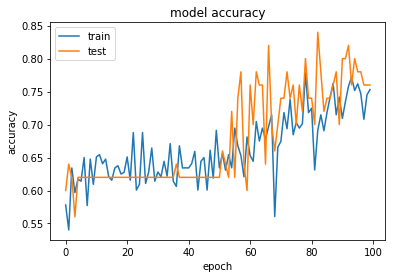

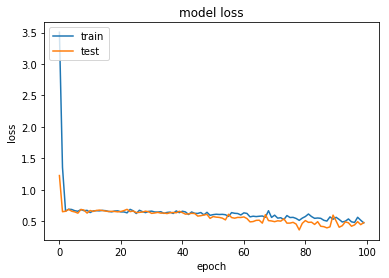

In [20]:
# summarize history for accuracy
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [14]:
model_final.save('model_toni.h5')

In [15]:
df[df.toni_y.notnull()].shape

(402, 3)